# Установка и импортирование библиотек, загрузка данных.

In [ ]:
!pip install catboost
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
test_df = pd.read_csv('test.csv')

# EDA

### EDA for all models

In [ ]:
df.head(3)

,apartment_id,building_age_years,wing,entrance,floor,apartment_area_m2,ceiling_height_m,window_quality,heating_type,corner_apartment,...,stand_type,cut_days_before_jan1,potted_tree,waterings_per_week,mist_spray,tinsel_level,ornaments_weight_kg,led_garland,garland_hours_per_day,survived_to_18jan
0,apt_train_000001,27,east,6,16,58.7,2.73,new,central,1,...,bucket,10,0,1.0,1,high,4.53,0,11.3,1
1,apt_train_000002,27,west,9,20,61.9,2.72,normal,electric_heater,1,...,bucket,12,0,1.0,1,low,NaN,0,2.9,0
2,apt_train_000003,27,north,2,9,48.0,2.48,normal,central,0,...,simple_stand,0,0,2.0,0,medium,3.17,1,15.2,0


In [ ]:
df.shape

(30000, 30)

In [ ]:
df.drop(columns=['apartment_id'], inplace=True)

In [ ]:
df['building_age_years'].value_counts()

,count
building_age_years,
27,30000


In [ ]:
df.drop(columns=['building_age_years'], inplace=True)

In [ ]:
test_df.drop(columns=['apartment_id', 'building_age_years'], inplace=True)

In [ ]:
df.isna().sum()

,0
wing,0
entrance,0
floor,0
apartment_area_m2,0
ceiling_height_m,892
window_quality,0
heating_type,0
corner_apartment,0
room_temp_c,0
window_ventilation_per_day,0


### EDA not for CatBoost

#### Discrete features

In [ ]:
discrete_cols = ['wing', 'entrance', 'floor', 'window_quality', 'heating_type',
                 'corner_apartment', 'window_ventilation_per_day', 'children_count',
                 'cat_present', 'robot_vacuum', 'tree_species', 'tree_form',
                 'stand_type', 'cut_days_before_jan1', 'potted_tree',
                 'waterings_per_week', 'mist_spray', 'tinsel_level',
                 'led_garland']

In [ ]:
len(discrete_cols)

19

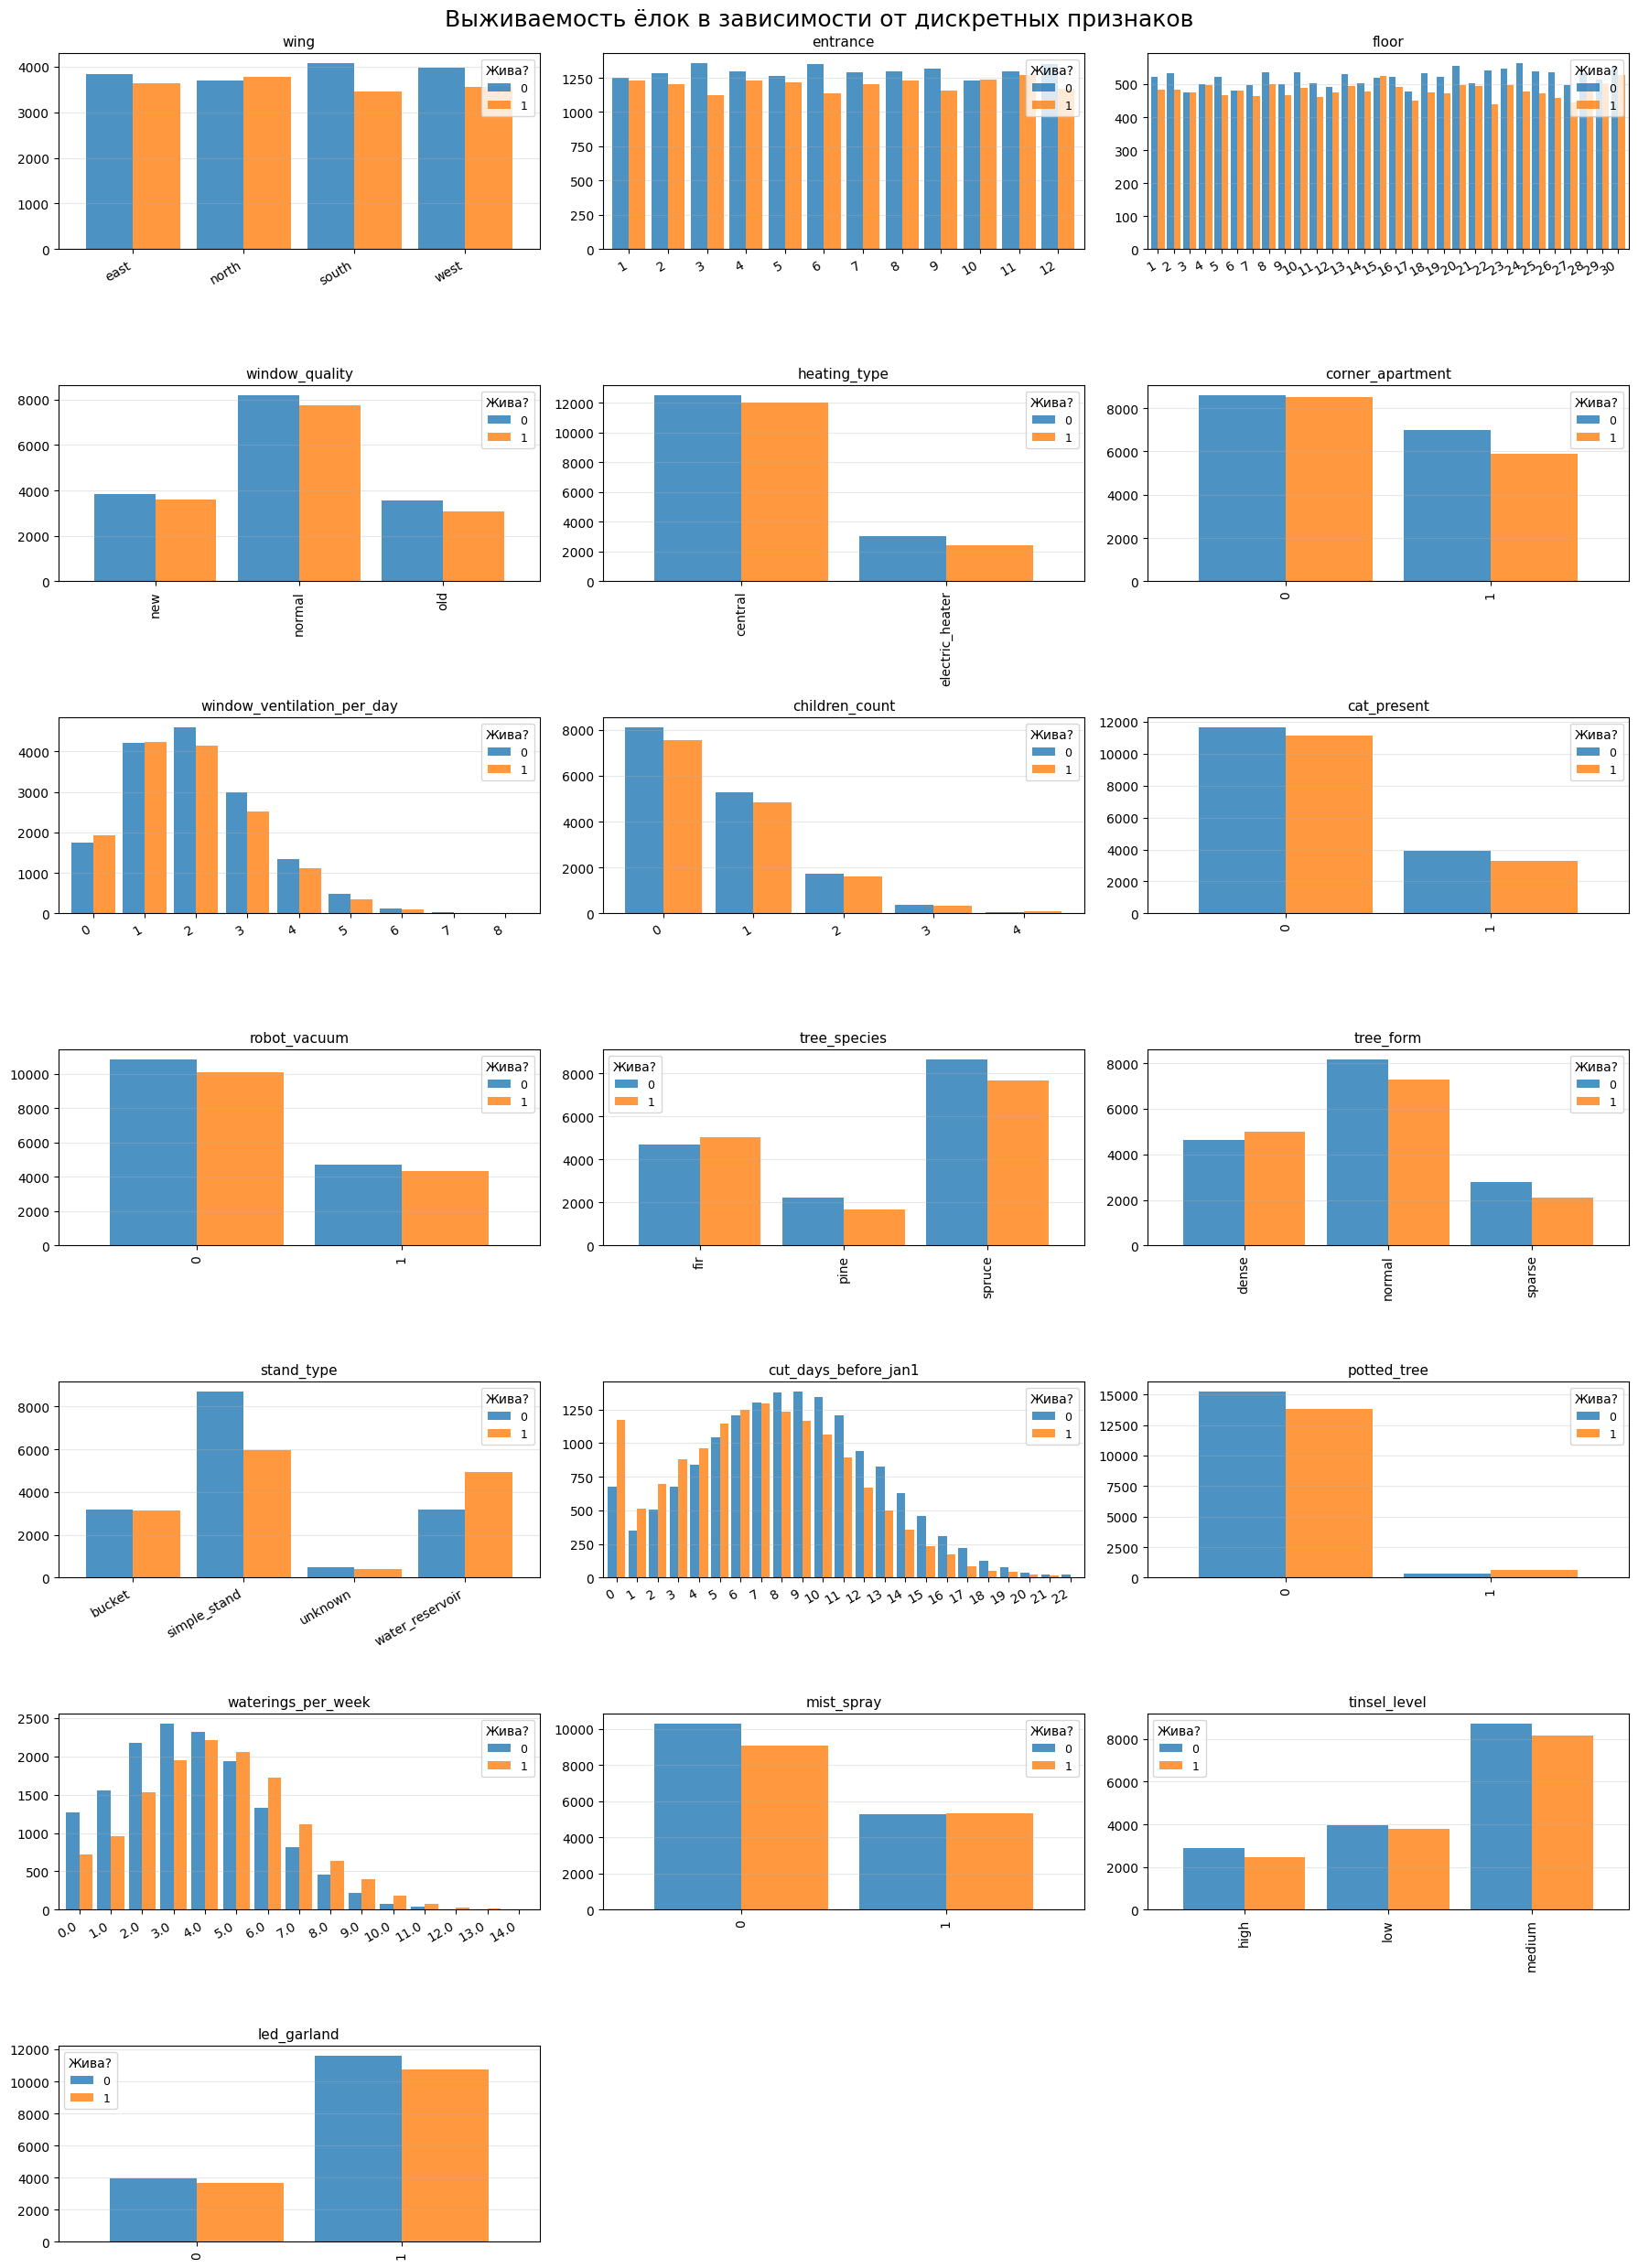

In [ ]:
n_rows = 7
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 25))

for i, column in enumerate(discrete_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    tmp = pd.concat([df[column], df['survived_to_18jan']], axis=1)
    agg = tmp.groupby([column, 'survived_to_18jan']).size().unstack(fill_value=0)

    agg.plot(kind='bar', ax=ax, alpha=0.8, width=0.85)

    ax.set_title(column, fontsize=11)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3, axis='y')

    if len(agg) > 3:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.legend(title='Жива?', fontsize=9)

for i in range(len(discrete_cols), n_rows * n_cols):
    axes.flatten()[i].set_visible(False)

plt.suptitle('Выживаемость ёлок в зависимости от дискретных признаков', fontsize=18, y=0.99)
plt.tight_layout()
plt.show()

Глядя на графики, следует уделить внимание признакам```cut_days_before_janl```, ```waterings_ per_week``` и ```stand_type```.

У всех остальных дискретных признаков распределение выживаемости елок между уникальными значениями признака примерно одинаково.

##### Feature `stand_type`

```stand_type``` — подставка: simple_stand/bucket/water_reservoir/unknown

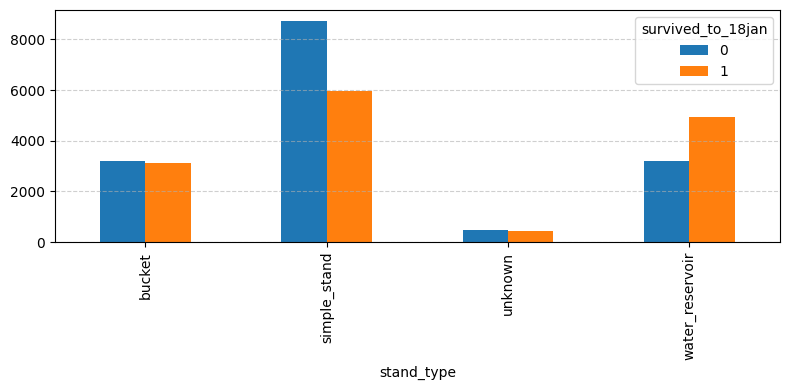

In [ ]:
tmp = pd.concat([df['stand_type'], df['survived_to_18jan']], axis=1)

agg = tmp.groupby(['stand_type', 'survived_to_18jan']).size().unstack(fill_value=0)
agg.plot(kind='bar', figsize=(8,4))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
agg

survived_to_18jan,0,1
stand_type,,
bucket,3194,3130
simple_stand,8725,5945
unknown,467,419
water_reservoir,3197,4923


In [ ]:
df['stand_type']

,stand_type
0,bucket
1,bucket
2,simple_stand
3,water_reservoir
4,water_reservoir
...,...
29995,simple_stand
29996,simple_stand
29997,bucket
29998,simple_stand


In [ ]:
df.loc[df['stand_type'] == 'unknown', 'stand_type'] = 'bucket'

In [ ]:
test_df.loc[test_df['stand_type'] == 'unknown', 'stand_type'] = 'bucket'

In [ ]:
df['stand_type'].unique()

array(['bucket', 'simple_stand', 'water_reservoir'], dtype=object)

In [ ]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = ohe.fit_transform(df[['stand_type']])

In [ ]:
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['stand_type']))

In [ ]:
df_enc = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
df_enc.drop(columns='stand_type', inplace=True)

df = df_enc

In [ ]:
test_encoded_data = ohe.transform(test_df[['stand_type']])

test_encoded_df = pd.DataFrame(
    test_encoded_data,
    columns=ohe.get_feature_names_out(['stand_type']),
    index=test_df.index
)

test_df_enc = pd.concat([test_df.reset_index(drop=True), test_encoded_df], axis=1)
test_df_enc.drop(columns='stand_type', inplace=True)

In [ ]:
test_df = test_df_enc

In [ ]:
df.head(3)

,wing,entrance,floor,apartment_area_m2,ceiling_height_m,window_quality,heating_type,corner_apartment,room_temp_c,window_ventilation_per_day,...,waterings_per_week,mist_spray,tinsel_level,ornaments_weight_kg,led_garland,garland_hours_per_day,survived_to_18jan,stand_type_bucket,stand_type_simple_stand,stand_type_water_reservoir
0,east,6,16,58.7,2.73,new,central,1,21.8,1,...,1.0,1,high,4.53,0,11.3,1,1.0,0.0,0.0
1,west,9,20,61.9,2.72,normal,electric_heater,1,21.9,1,...,1.0,1,low,NaN,0,2.9,0,1.0,0.0,0.0
2,north,2,9,48.0,2.48,normal,central,0,20.0,0,...,2.0,0,medium,3.17,1,15.2,0,0.0,1.0,0.0


In [ ]:
discrete_cols.remove('stand_type')

##### Feature `cut_days_before_jan1`

```cut_days_before_jan1``` — за сколько дней до 1 января ёлку срубили (0–22)

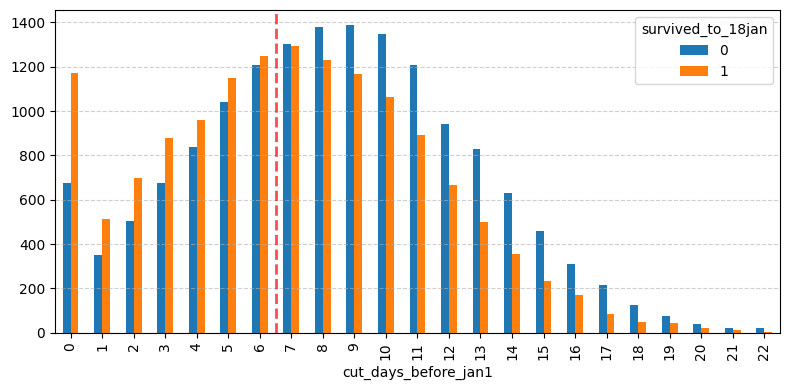

In [ ]:
tmp = pd.concat([df['cut_days_before_jan1'], df['survived_to_18jan']], axis=1)

agg = tmp.groupby(['cut_days_before_jan1', 'survived_to_18jan']).size().unstack(fill_value=0)
agg.plot(kind='bar', figsize=(8,4))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.axvline(x=6.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

При срублении ёлки за 0-6 дней до 1 января, она преимущественно выживала до 18 января, за 7-22 дня - преимещуственно умирала

In [ ]:
df.loc[df['cut_days_before_jan1'] <= 6, 'cut_days_before_jan1'] = 1
df.loc[df['cut_days_before_jan1'] > 6, 'cut_days_before_jan1'] = 0

In [ ]:
test_df.loc[test_df['cut_days_before_jan1'] <= 6, 'cut_days_before_jan1'] = 1
test_df.loc[test_df['cut_days_before_jan1'] > 6, 'cut_days_before_jan1'] = 0

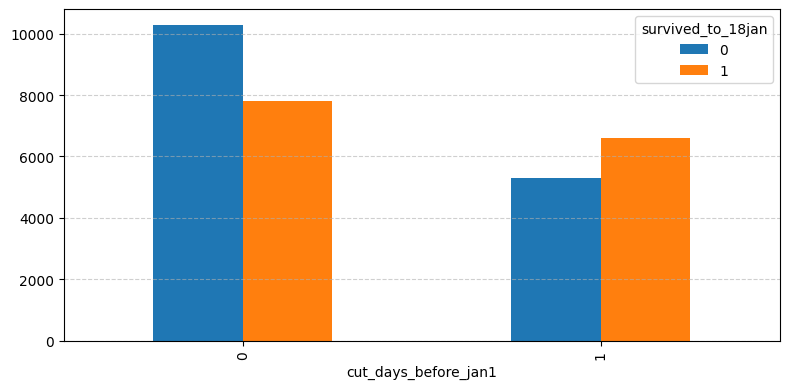

In [ ]:
tmp = pd.concat([df['cut_days_before_jan1'], df['survived_to_18jan']], axis=1)

agg = tmp.groupby(['cut_days_before_jan1', 'survived_to_18jan']).size().unstack(fill_value=0)
agg.plot(kind='bar', figsize=(8,4))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

##### Feature `waterings_per_week`

`waterings_per_week` — поливов в неделю (0–14)

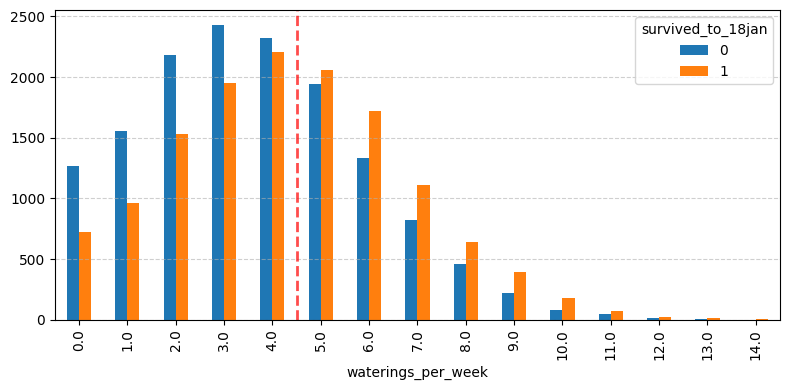

In [ ]:
tmp = pd.concat([df['waterings_per_week'], df['survived_to_18jan']], axis=1)

agg = tmp.groupby(['waterings_per_week', 'survived_to_18jan']).size().unstack(fill_value=0)
agg.plot(kind='bar', figsize=(8,4))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.axvline(x=4.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

можно заметить, что елки, которые поливали 0-4 раза в неделю погибали чаще, чем ёлки, которые поливали 5-14 раз в неделю

In [ ]:
df.loc[df['waterings_per_week'] <= 4, 'waterings_per_week'] = 0
df.loc[df['waterings_per_week'] > 4, 'waterings_per_week'] = 1

In [ ]:
test_df.loc[test_df['waterings_per_week'] <= 4, 'waterings_per_week'] = 0
test_df.loc[test_df['waterings_per_week'] > 4, 'waterings_per_week'] = 1

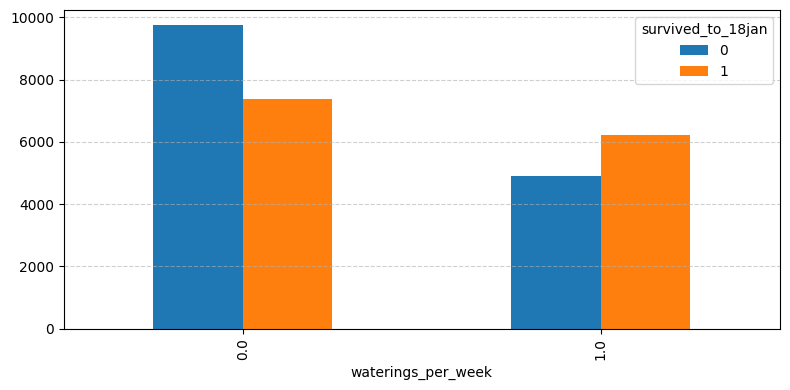

In [ ]:
tmp = pd.concat([df['waterings_per_week'], df['survived_to_18jan']], axis=1)

agg = tmp.groupby(['waterings_per_week', 'survived_to_18jan']).size().unstack(fill_value=0)
agg.plot(kind='bar', figsize=(8,4))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

##### Ending

In [ ]:
df[discrete_cols].isna().sum()

,0
wing,0
entrance,0
floor,0
window_quality,0
heating_type,0
corner_apartment,0
window_ventilation_per_day,0
children_count,0
cat_present,0
robot_vacuum,0


In [ ]:
df[df['waterings_per_week'] == 1].shape[0] / (df[df['waterings_per_week'].isna() == False].shape[0])

0.3939544103072349

In [ ]:
np.random.seed(42)

In [ ]:
proba_1 = 0.4
mask = df['waterings_per_week'].isna()

df.loc[mask, 'waterings_per_week'] = np.random.choice(
    [1, 0],
    size=mask.sum(),
    p=[proba_1, 1 - proba_1]
    )

In [ ]:
proba_1 = 0.4
mask = test_df['waterings_per_week'].isna()

test_df.loc[mask, 'waterings_per_week'] = np.random.choice(
    [1, 0],
    size=mask.sum(),
    p=[proba_1, 1 - proba_1]
    )

In [ ]:
df[df['waterings_per_week'] == 1].shape[0] / (df[df['waterings_per_week'].isna() == False].shape[0])

0.39466666666666667

In [ ]:
df[discrete_cols].isna().sum()

,0
wing,0
entrance,0
floor,0
window_quality,0
heating_type,0
corner_apartment,0
window_ventilation_per_day,0
children_count,0
cat_present,0
robot_vacuum,0


#### Continious features

In [ ]:
continuous_cols = ['apartment_area_m2', 'ceiling_height_m', 'room_temp_c', 'humidity_pct',
                   'radiator_distance_m', 'tree_height_cm',
                   'ornaments_weight_kg', 'garland_hours_per_day']

In [ ]:
len(continuous_cols)

8

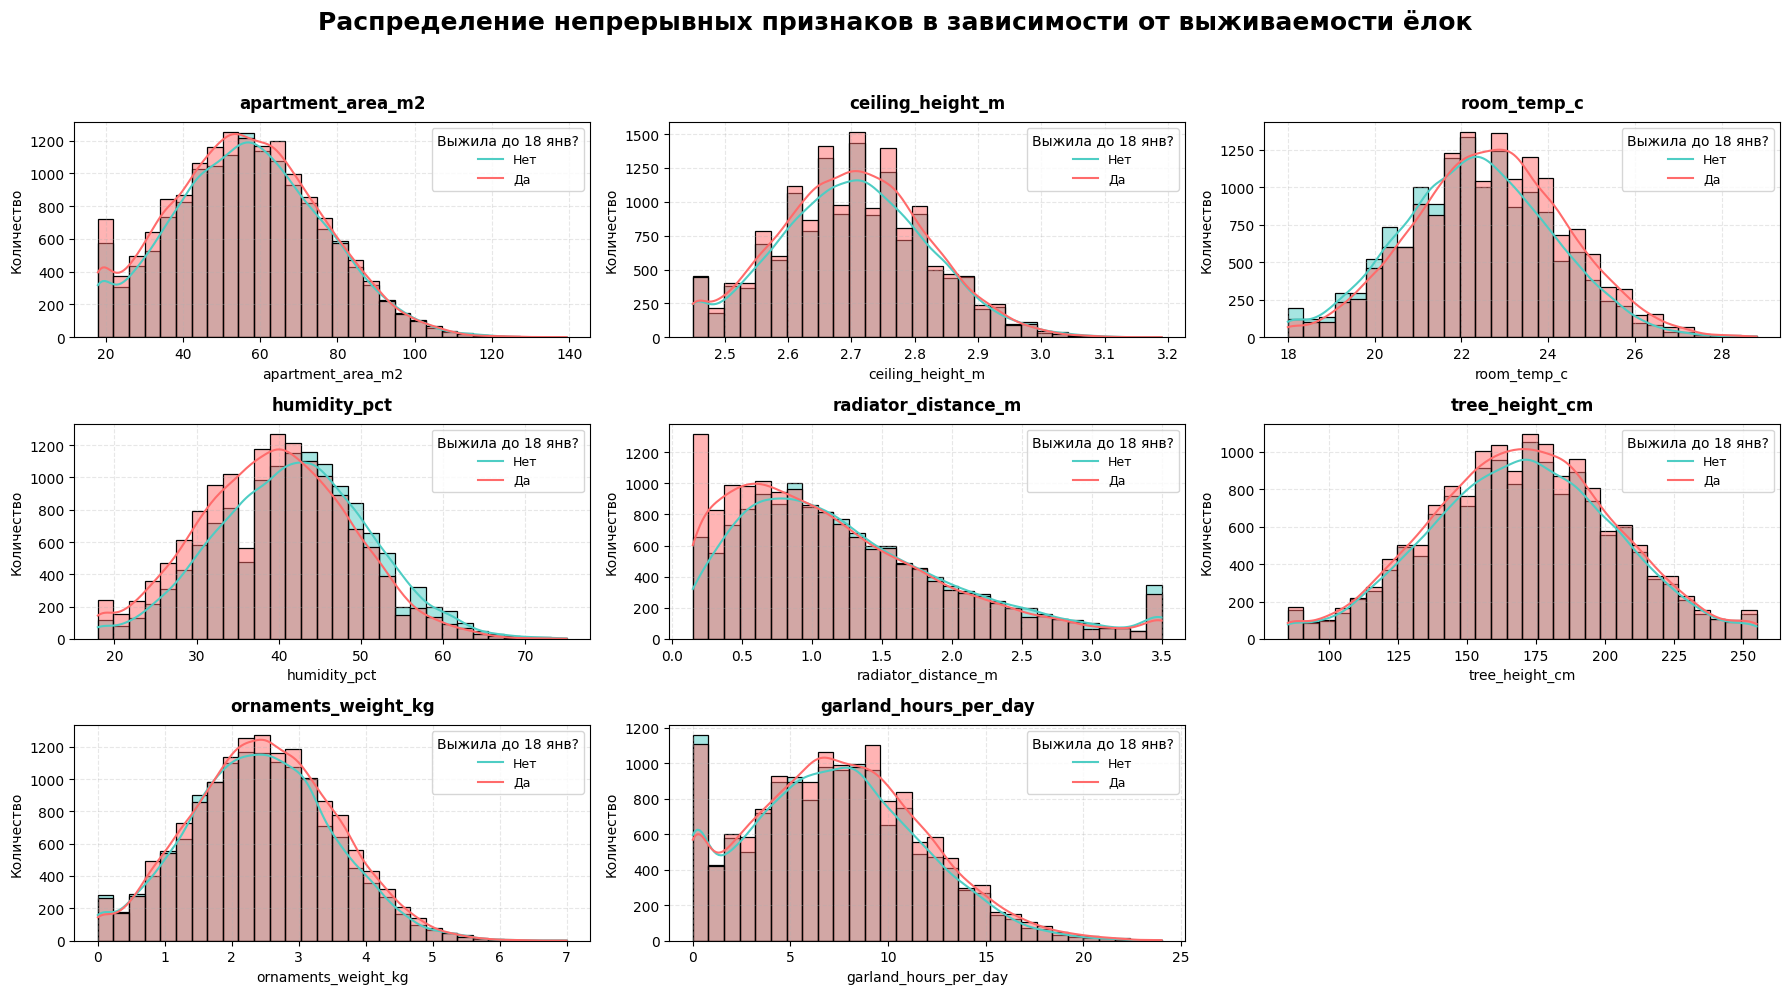

In [ ]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))

for i, column in enumerate(continuous_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    sns.histplot(
            data=df,
            x=column,
            hue='survived_to_18jan',
            kde=True,
            bins=30,
            alpha=0.5,
            ax=ax,
            palette=['#FF6B6B', '#4ECDC4']
        )

    ax.set_title(column, fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Количество', fontsize=10)

    ax.legend(
        title='Выжила до 18 янв?',
        labels=['Нет', 'Да'],
        fontsize=9,
        title_fontsize=10
    )

    ax.grid(True, alpha=0.3, linestyle='--')

    # stats_text = (f"Mean: {df[column].mean():.2f}\n"
    #               f"Std: {df[column].std():.2f}\n"
    #               f"N: {df[column].notna().sum()}")

    # ax.text(
    #     0.95, 0.95,
    #     stats_text,
    #     transform=ax.transAxes,
    #     fontsize=8,
    #     verticalalignment='top',
    #     horizontalalignment='right',
    #     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # )

for i in range(len(continuous_cols), n_rows * n_cols):
    axes.flatten()[i].set_visible(False)

plt.suptitle('Распределение непрерывных признаков в зависимости от выживаемости ёлок',
             fontsize=18, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Глядя на построенные графики, обратим внимание на признаки `humidity_pct` и `radiator_distance_m`.

In [ ]:
df[continuous_cols].isna().sum()

,0
apartment_area_m2,0
ceiling_height_m,892
room_temp_c,0
humidity_pct,2176
radiator_distance_m,1225
tree_height_cm,0
ornaments_weight_kg,1534
garland_hours_per_day,1480


In [ ]:
def stochastic_impute(series, random_state=42):
    rng = np.random.default_rng(random_state)
    observed = series.dropna().values
    mask = series.isna()

    series = series.copy()
    series.loc[mask] = rng.choice(observed, size=mask.sum(), replace=True)
    return series

##### Feature `radiator_distance_m`

`radiator_distance_m` — расстояние до батареи (м)

In [ ]:
df['radiator_distance_m'].describe()

,radiator_distance_m
count,28775.000000
mean,1.214969
std,0.789048
min,0.150000
25%,0.610000
50%,1.050000
75%,1.650000
max,3.500000


In [ ]:
df['radiator_distance_m'].isna().sum()

np.int64(1225)

In [ ]:
df['radiator_distance_m'] = stochastic_impute(df['radiator_distance_m'])

In [ ]:
test_df['radiator_distance_m'] = stochastic_impute(test_df['radiator_distance_m'])

In [ ]:
df['radiator_distance_m'].isna().sum()

np.int64(0)

Так как график распределения величин признака достаточно нестандартный, заполнять пропуски стоит тоже достаточно нестандартными методами. Нужно, чтобы ёлки, которые могут стоять потенциально ближе к батарее получили меньшее значение признака, иначе - большее. Используем для этого кластеризацию.

In [ ]:
def fill_radiator_with_clustering(df, n_clusters=3):
    df_filled = df.copy()

    # Шаг 1: Кластеризуем существующие данные
    existing_data = df_filled[df_filled['radiator_distance_m'].notna()].copy()

    if len(existing_data) > n_clusters:
        # Используем KMeans для кластеризации
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        existing_data['cluster'] = kmeans.fit_predict(
            existing_data[['radiator_distance_m', 'survived_to_18jan']]
        )

        # Шаг 2: Для каждого кластера вычисляем характеристики
        cluster_stats = existing_data.groupby('cluster').agg({
            'radiator_distance_m': ['mean', 'std', 'count'],
            'survived_to_18jan': 'mean'
        }).round(3)

        # Шаг 3: Заполняем пропуски
        for idx, row in df_filled[df_filled['radiator_distance_m'].isna()].iterrows():
            # Находим ближайший кластер по survived_to_18jan
            closest_cluster = None
            min_distance = float('inf')

            for cluster_id in range(n_clusters):
                cluster_survival_rate = cluster_stats.loc[cluster_id, ('survived_to_18jan', 'mean')]
                distance = abs(row['survived_to_18jan'] - cluster_survival_rate)

                if distance < min_distance:
                    min_distance = distance
                    closest_cluster = cluster_id

            # Заполняем значением из кластера
            cluster_mean = cluster_stats.loc[closest_cluster, ('radiator_distance_m', 'mean')]
            cluster_std = cluster_stats.loc[closest_cluster, ('radiator_distance_m', 'std')]

            # Генерируем случайное значение с небольшим шумом
            filled_value = np.random.normal(cluster_mean, cluster_std * 0.3)
            # Ограничиваем разумными пределами
            filled_value = max(0, min(filled_value, 3.5))

            df_filled.loc[idx, 'radiator_distance_m'] = filled_value

    else:
        # Если мало данных, используем простой метод
        df_filled['radiator_distance_m'] = df_filled['radiator_distance_m'].fillna(
            df_filled['radiator_distance_m'].median()
        )

    return df_filled

df = fill_radiator_with_clustering(df, n_clusters=3)

Глядя на график распределения `radiator_distance_m`, можно понять, что ёлки, стоящие на расстоянии 0.15-0.7(м) от батареи, выживали чаще.

Исходя из этого, хочется при подаче признака в модель, уменьшать вес признака `radiator_distance_m` при отдалении ёлки от батареии (при увеличении значения `radiator_distance_m`). Реализуем экспоненциальное затухание и создадим новый признак

In [ ]:
df['radiator_exp_continuous'] = np.exp(-df['radiator_distance_m'] * 2)

In [ ]:
test_df['radiator_exp_continuous'] = np.exp(-test_df['radiator_distance_m'] * 2)

In [ ]:
df.drop(columns='radiator_distance_m', inplace=True)

In [ ]:
test_df.drop(columns='radiator_distance_m', inplace=True)

In [ ]:
continuous_cols.remove('radiator_distance_m')

##### Feature `humidity_pct`

`humidity_pct` — средняя влажность воздуха (%)

In [ ]:
df['humidity_pct'].isna().sum()

np.int64(2176)

In [ ]:
df['humidity_pct'] = stochastic_impute(df['humidity_pct'])

In [ ]:
test_df['humidity_pct'] = stochastic_impute(test_df['humidity_pct'])

In [ ]:
df['humidity_pct'].isna().sum()

np.int64(0)

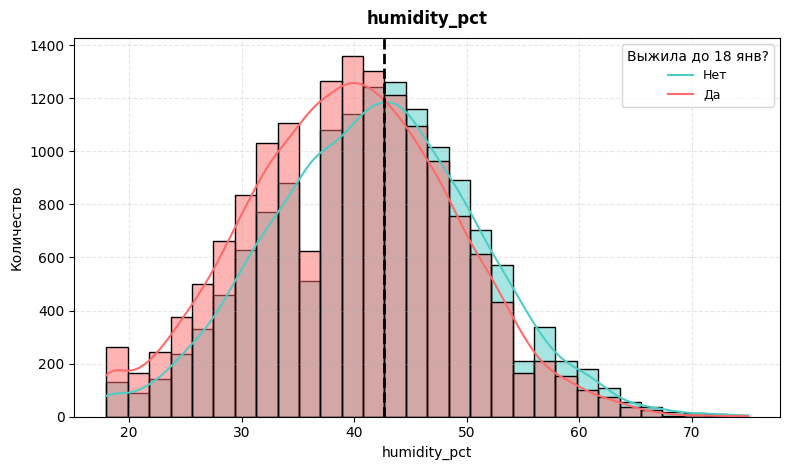

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(
    data=df,
    x='humidity_pct',
    hue='survived_to_18jan',
    kde=True,
    bins=30,
    alpha=0.5,
    ax=ax,
    palette=['#FF6B6B', '#4ECDC4']
)

ax.set_title('humidity_pct', fontsize=12, fontweight='bold', pad=10)
ax.set_ylabel('Количество', fontsize=10)

ax.legend(
    title='Выжила до 18 янв?',
    labels=['Нет', 'Да'],
    fontsize=9,
    title_fontsize=10
)

ax.grid(True, alpha=0.3, linestyle='--')

ax.axvline(
    x=42.7,
    color='black',
    linestyle='--',
    linewidth=2
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
df['humidity_advantage'] = (df['humidity_pct'] <= 42.5).astype(int)

In [ ]:
test_df['humidity_advantage'] = (test_df['humidity_pct'] <= 42.5).astype(int)

##### Ending

In [ ]:
df[continuous_cols].isna().sum()

,0
apartment_area_m2,0
ceiling_height_m,892
room_temp_c,0
humidity_pct,0
tree_height_cm,0
ornaments_weight_kg,1534
garland_hours_per_day,1480


In [ ]:
for c in continuous_cols:
  if df[c].isna().sum() > 0:
    df[c] = stochastic_impute(df[c])

In [ ]:
for c in continuous_cols:
  if test_df[c].isna().sum() > 0:
    test_df[c] = stochastic_impute(test_df[c])

In [ ]:
df[continuous_cols].isna().sum()

,0
apartment_area_m2,0
ceiling_height_m,0
room_temp_c,0
humidity_pct,0
tree_height_cm,0
ornaments_weight_kg,0
garland_hours_per_day,0


#### Categorial data

In [ ]:
df.dtypes

,0
wing,object
entrance,int64
floor,int64
apartment_area_m2,float64
ceiling_height_m,float64
window_quality,object
heating_type,object
corner_apartment,int64
room_temp_c,float64
window_ventilation_per_day,int64


In [ ]:
cat_cols = ['wing', 'window_quality', 'heating_type', 'tree_species',
            'tree_form', 'tinsel_level']

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int64)

encoded_array = encoder.fit_transform(df[cat_cols])
feature_names = encoder.get_feature_names_out(cat_cols)
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)

df = df.drop(cat_cols, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [ ]:
test_encoded_array = encoder.transform(test_df[cat_cols])

test_encoded_df = pd.DataFrame(
    test_encoded_array,
    columns=feature_names,
    index=test_df.index
)

test_df = test_df.drop(cat_cols, axis=1)

test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [ ]:
df.dtypes

,0
entrance,int64
floor,int64
apartment_area_m2,float64
ceiling_height_m,float64
corner_apartment,int64
room_temp_c,float64
window_ventilation_per_day,int64
humidity_pct,float64
children_count,int64
cat_present,int64


### EDA for CatBoost

In [ ]:
df.dtypes

,0
wing,object
entrance,int64
floor,int64
apartment_area_m2,float64
ceiling_height_m,float64
window_quality,object
heating_type,object
corner_apartment,int64
room_temp_c,float64
window_ventilation_per_day,int64


In [ ]:
cat_cols = ['wing', 'window_quality', 'heating_type', 'tree_species', 'tree_form', 'stand_type', 'tinsel_level']

#Train test split

In [ ]:
X = df.drop(columns='survived_to_18jan')
y = df['survived_to_18jan']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Запустить перед обучением логистической регрессии!

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
test_scaled = scaler.transform(test_df)

# Model Selection

## Logistic regression

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

np.float64(0.6622946000385149)

In [ ]:
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
}

grid_logreg = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid=param_grid,
    cv=4,
    verbose=4,
    scoring='roc_auc'
)

In [ ]:
grid_logreg.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END .............................C=0.1;, score=0.664 total time=   0.2s
[CV 2/4] END .............................C=0.1;, score=0.654 total time=   0.2s
[CV 3/4] END .............................C=0.1;, score=0.668 total time=   0.2s
[CV 4/4] END .............................C=0.1;, score=0.657 total time=   0.1s
[CV 1/4] END .............................C=0.5;, score=0.664 total time=   0.2s
[CV 2/4] END .............................C=0.5;, score=0.654 total time=   0.3s
[CV 3/4] END .............................C=0.5;, score=0.668 total time=   0.3s
[CV 4/4] END .............................C=0.5;, score=0.657 total time=   0.3s
[CV 1/4] END ...............................C=1;, score=0.664 total time=   0.3s
[CV 2/4] END ...............................C=1;, score=0.654 total time=   0.3s
[CV 3/4] END ...............................C=1;, score=0.668 total time=   0.3s
[CV 4/4] END ...............................C=1;,

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 0.5, 1, 5, 10]}, scoring='roc_auc',
             verbose=4)

In [ ]:
best_grid_logreg = grid_logreg.best_estimator_

In [ ]:
y_proba = best_grid_logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

np.float64(0.6622946000385149)

## CatBoost

In [ ]:
X = df.drop(columns='survived_to_18jan')
y = df['survived_to_18jan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
cb_model = CatBoostClassifier(verbose=0, task_type="GPU")

In [ ]:
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
params = cb_model.get_all_params()
print(params)

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'Logloss', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'max_ctr_

In [ ]:
y_pred = cb_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

0.6787769070170221


### Tuning

In [ ]:
from catboost import Pool, cv

cv_dataset = Pool(data=X, label=y, cat_features=cat_cols)
params = {
    "iterations": 1200,
    "depth": 6,
    "loss_function": "Logloss",
    "verbose": False,
    "eval_metric": "AUC"
}

scores = cv(cv_dataset, params, fold_count=3, plot=True)

best_iteration = scores['test-AUC-mean'].idxmax() + 1

cb_cv = CatBoostClassifier(
    iterations=best_iteration,
    depth=6,
    loss_function="Logloss",
    verbose=100
)

cb_cv.fit(X, y, cat_features=cat_cols)

y_pred = cb_cv.predict_proba(test_df)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.663927069
bestIteration = 427

Training on fold [1/3]

bestTest = 0.6753819871
bestIteration = 402

Training on fold [2/3]

bestTest = 0.6742595414
bestIteration = 354

Learning rate set to 0.101298
0:	learn: 0.6872554	total: 70.8ms	remaining: 28.5s
100:	learn: 0.6269591	total: 5.25s	remaining: 15.7s
200:	learn: 0.6038610	total: 9.7s	remaining: 9.74s
300:	learn: 0.5840258	total: 15.2s	remaining: 5.15s
400:	learn: 0.5666130	total: 19.9s	remaining: 99.1ms
402:	learn: 0.5662345	total: 20s	remaining: 0us


In [ ]:
cb_cv.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 403,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderT

## XGBoost

In [ ]:
xg = XGBClassifier()

In [ ]:
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xg.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

0.630066035751279


# Submission

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
y_submission = xg.predict_proba(test_scaled)[:, 1]
submission['survived_to_18jan'] = y_submission

In [ ]:
submission

,apartment_id,survived_to_18jan
0,apt_000001,0.833843
1,apt_000002,0.790279
2,apt_000003,0.857458
3,apt_000004,0.434669
4,apt_000005,0.742544
...,...,...
17995,apt_017996,0.926080
17996,apt_017997,0.646060
17997,apt_017998,0.419757
17998,apt_017999,0.899901


In [ ]:
submission.to_csv("/content/xg_submission.csv", index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')